In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug
import tensorflow as tf

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPool2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

In [47]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [49]:
import os

# Navigate to the directory containing the zip file
os.chdir('/content/drive/MyDrive/')

# Unzip the file in the same folder with its original name
!unzip -q 'data_week1.zip'


In [50]:
datasets = ['/content/drive/MyDrive/data_week1/images']

class_names = ["MILK","NUTS","OIL","SODA","TEA"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'MILK': 0, 'NUTS': 1, 'OIL': 2, 'SODA': 3, 'TEA': 4}

In [51]:
def load_data():
    images, labels = [], []

    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]

            for file in tqdm(os.listdir(os.path.join(dataset,folder))):

                img_path = os.path.join(dataset,folder,file)

                img = cv2.imread(img_path)
                img = cv2.resize(img, (96,96))

                images.append(img)
                labels.append(label)
                pass
            pass

        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass

    return (images, labels)
    pass

In [52]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 283/283 [00:02<00:00, 104.01it/s]


((933, 96, 96, 3), (933,))

In [53]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)

In [55]:
print(df)

             Count
Class-Label       
MILK           162
NUTS           168
OIL            143
SODA           177
TEA            283


In [56]:
def augment_add(images, seq, labels):

    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):

        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)

    return (augmented_images, augmented_labels)
    pass

In [57]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [58]:
(aug_images, aug_labels) = augment_add(images, seq, labels)
images = np.concatenate([images, aug_images])
labels = np.concatenate([labels, aug_labels])

933it [00:00, 1279.15it/s]


In [59]:
images.shape, labels.shape

((1269, 96, 96, 3), (1269,))

In [60]:
labels = to_categorical(labels)

In [61]:
labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [62]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

In [63]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((888, 96, 96, 3), (253, 96, 96, 3), (126, 96, 96, 3))

In [64]:
model = Sequential([
    Input(shape=(96,96,3)),
    ZeroPadding2D((5,5)),
    Conv2D(32, 3, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.4),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPadd  (None, 106, 106, 3)       0         
 ing2D)                                                          
                                                                 
 conv2d_5 (Conv2D)           (None, 104, 104, 32)      896       
                                                                 
 batch_normalization_1 (Bat  (None, 104, 104, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 52, 52, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 52, 52, 32)        0         
                                                      

In [66]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    save_frequency=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=50,
    verbose=1,
    mode='auto'
)

opt = Adam(lr=1e-3)

callbacks = [checkpoint,earlystop]

model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [67]:
epochs = 200
batch_size = 32

history = model.fit(train_images,train_labels,
                    batch_size=batch_size,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=callbacks
                   )

Epoch 1/200
26/27 [===========================>..] - ETA: 0s - loss: 0.6017 - accuracy: 0.2584
Epoch 1: val_accuracy improved from -inf to 0.41964, saving model to ./base.model
27/27 [==============================] - 6s 100ms/step - loss: 0.5987 - accuracy: 0.2627 - val_loss: 0.6672 - val_accuracy: 0.4196
Epoch 2/200
25/27 [==========================>...] - ETA: 0s - loss: 0.5149 - accuracy: 0.3371
Epoch 2: val_accuracy did not improve from 0.41964
27/27 [==============================] - 1s 23ms/step - loss: 0.5171 - accuracy: 0.3353 - val_loss: 0.6456 - val_accuracy: 0.4196
Epoch 3/200
26/27 [===========================>..] - ETA: 0s - loss: 0.5031 - accuracy: 0.3592
Epoch 3: val_accuracy did not improve from 0.41964
27/27 [==============================] - 1s 19ms/step - loss: 0.5025 - accuracy: 0.3586 - val_loss: 0.6308 - val_accuracy: 0.4196
Epoch 4/200
26/27 [===========================>..] - ETA: 0s - loss: 0.4970 - accuracy: 0.3641
Epoch 4: val_accuracy did not improve from 0.

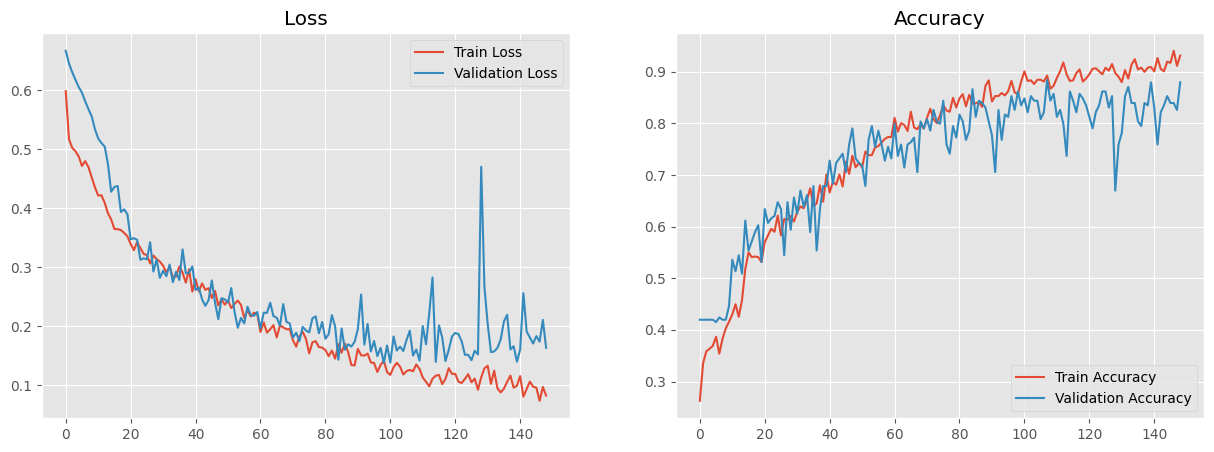

Weights Saved


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
show_final_history(history)
model.save("model.h5")
print("Weights Saved")

In [69]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_actual = np.argmax(test_labels,axis=1)
rnd_idx = random.sample(range(0,100),10)

4/4 [==============================] - 0s 4ms/step


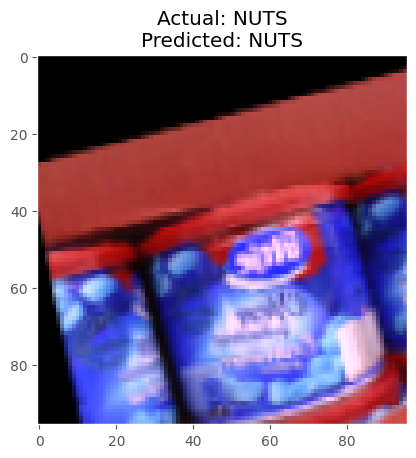

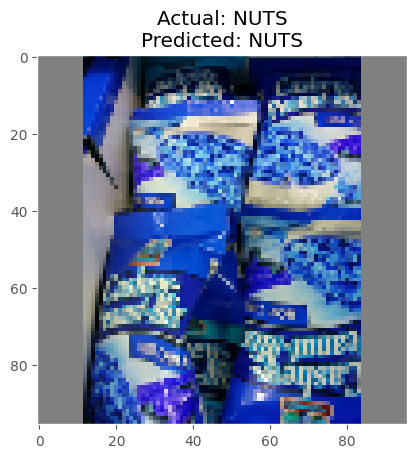

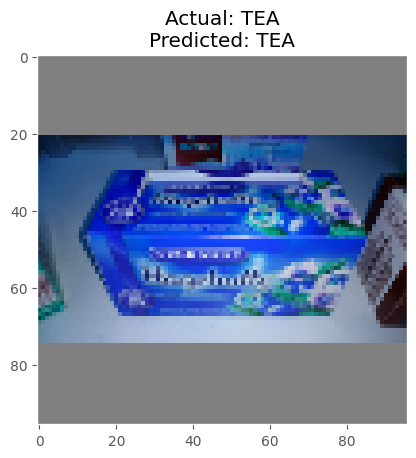

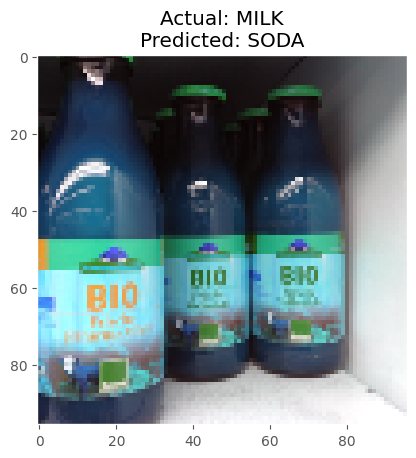

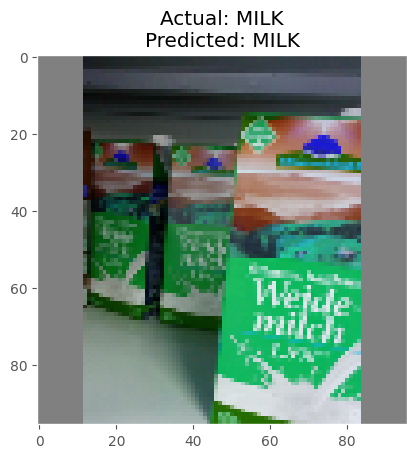

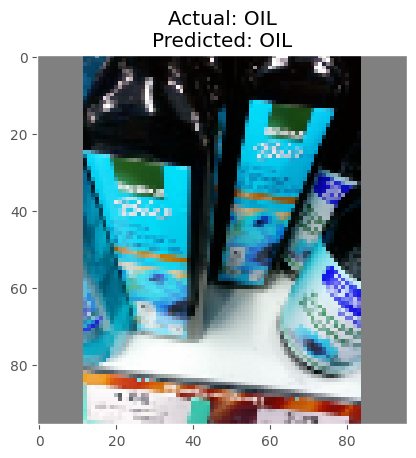

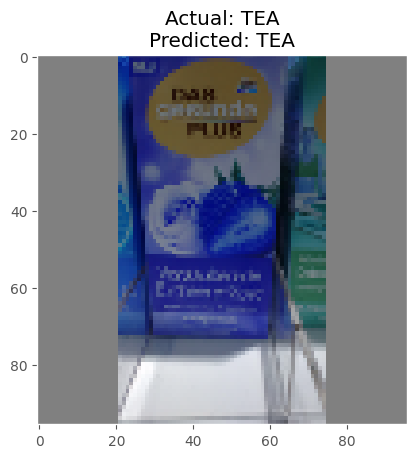

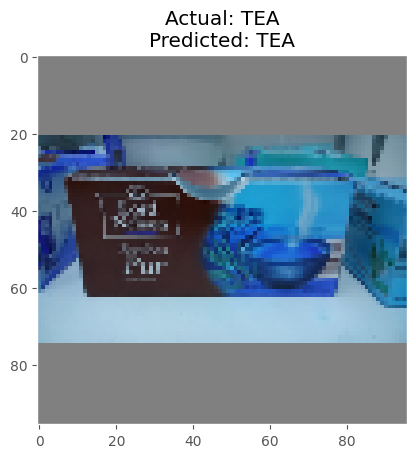

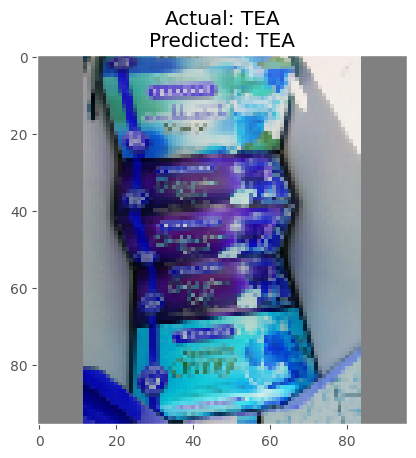

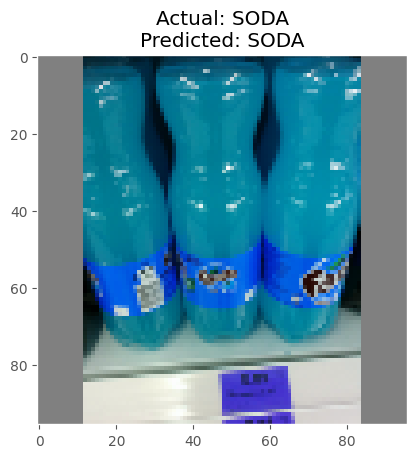

In [70]:
class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
for i,idx in enumerate(rnd_idx):
    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass